Some reference:

SchNet: https://doi.org/10.1063/1.5019779

PyTorch Documentation: https://pytorch.org/docs/stable/index.html

PyTorch Geometric Documentation: https://pytorch-geometric.readthedocs.io/en/latest/

In [1]:
#load necessary packages
import pickle
import numpy as np
import pandas as pd
import torch_geometric
import torch
from torch_geometric.data import Data,DataLoader
import torch.nn as nn
import math
import datetime
from torch_geometric.nn import MessagePassing,global_mean_pool,global_add_pool
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
warnings.filterwarnings('ignore')

In [ ]:
use_device='cuda' if torch.cuda.is_available() else 'cpu' 

The following is the definition of RBF layer. The result of RBF layer can be used by every filter generator layer, so it can be used only once in the architecture of Schnet to reduce calculation.

In [2]:
class RBFLayer(nn.Module):
    def __init__(self,cutoff=6,gamma=0.1,rbfkernel_number=300):
        super(RBFLayer,self).__init__()
        self.cutoff=cutoff
        self.gamma=gamma
        self.rbfkernel_number=rbfkernel_number
        
    def forward(self,g):
        dist=torch.index_select(g.pos,0,g.edge_index[1])-torch.index_select(g.pos,0,g.edge_index[0])
        dist=torch.add(dist,g.edge_attr)
        dist=torch.norm(dist,p=2,dim=1,keepdim=True)
        centers=np.linspace(0,self.cutoff,self.rbfkernel_number,dtype=np.float32)
        rbf_kernel=torch.tensor(centers,device=use_device)
        rbf_tensor=dist-rbf_kernel
        rbf_tensor=torch.exp(-self.gamma*torch.mul(rbf_tensor,rbf_tensor))
        return rbf_tensor,dist

The definition of Filter generator block. It is used to generate the weight of cfconv layer.

In [3]:
class FilterGeneratorBlock(nn.Module):
    def __init__(self,rbfkernel_number=300,out_dim=64):
        super(FilterGeneratorBlock,self).__init__()
        self.linear1=nn.Linear(rbfkernel_number,out_dim)
        self.linear2=nn.Linear(out_dim,out_dim)
        
    def forward(self,rbf_tensor):
        weight=self.linear1(rbf_tensor)
        weight=torch.log(torch.exp(weight)+1.0)-torch.log(torch.tensor(2.0))
        weight=self.linear2(weight)
        weight=torch.log(torch.exp(weight)+1.0)-torch.log(torch.tensor(2.0))
        return weight

The definition of cfconv layer, which is used for carring out the graph convolution operation of every atom.

In [4]:
class cfconv(MessagePassing):
    def __init__(self,rbfkernel_number=300,feat_num=64,aggragate='add',node_flow='target_to_source'):
        super(cfconv,self).__init__(aggr=aggragate,flow=node_flow)
        self.filter_block=FilterGeneratorBlock(rbfkernel_number=rbfkernel_number,out_dim=feat_num)
     
    def message(self,x_j,weight):
        return torch.mul(x_j,weight)
    
    def update(self,aggr_out):
        return aggr_out
    
    def forward(self,x,edge_index,rbf_tensor,dist,cutoff):
        weight=self.filter_block(rbf_tensor)
        weight=weight*(1+torch.cos(3.14159265*dist/cutoff)) #a little modification of the original SchNet
        return self.propagate(edge_index,x=x,weight=weight)

The Interaction block is used to update node features.

In [5]:
class InteractionBlock(nn.Module):
    def __init__(self,rbfkernel_number=300,feat_num=64):
        super(InteractionBlock,self).__init__()
        self.linear1=nn.Linear(feat_num,feat_num)
        self.cfconvlayer=cfconv(rbfkernel_number=rbfkernel_number,feat_num=feat_num)
        self.linear2=nn.Linear(feat_num,feat_num)
        self.linear3=nn.Linear(feat_num,feat_num)
    
    def forward(self,edge_index,node_feature,rbf_tensor,dist,cutoff):
        x=torch.tensor(node_feature)
        node_feature=self.linear1(node_feature)
        node_feature=self.cfconvlayer(node_feature,edge_index,rbf_tensor,dist,cutoff)
        node_feature=self.linear2(node_feature)
        node_feature=torch.log(torch.exp(node_feature)+1.0)-torch.log(torch.tensor(2.0))
        node_feature=self.linear3(node_feature)
        node_feature=torch.add(node_feature,x)
        return node_feature

The architecture of Schnet.

In [6]:
class Schnet_init(nn.Module):
    def __init__(self,cutoff=6,gamma=0.5,rbfkernel_number=300,
                 hidden_layer_dimensions=64,num_conv=3,atom_types=1):
        super(Schnet_init,self).__init__()
        self.num_conv=num_conv
        self.cutoff=cutoff
        
        self.rbf_layer=RBFLayer(cutoff=cutoff,gamma=gamma,rbfkernel_number=rbfkernel_number)
        self.embedding=nn.Embedding(atom_types,hidden_layer_dimensions)
        self.interaction_blocks=InteractionBlock(feat_num=hidden_layer_dimensions,
                                                rbfkernel_number=rbfkernel_number)
        self.atomwise1=nn.Linear(hidden_layer_dimensions,int(hidden_layer_dimensions/2))
        self.atomwise2=nn.Linear(int(hidden_layer_dimensions/2),1)
        
    def forward(self,g):
        rbf_tensor,dist=self.rbf_layer(g)
        temp=self.embedding(g.x)
        for i in range(self.num_conv):
            temp=self.interaction_blocks(g.edge_index,temp,rbf_tensor,dist,self.cutoff)
        temp=self.atomwise1(temp)
        temp=torch.log(torch.exp(temp)+1.0)-torch.log(torch.tensor(2.0))
        temp=self.atomwise2(temp)
        temp=global_add_pool(temp,g.batch)
        return temp

In [7]:
class Schnet(nn.Module):
    def __init__(self,cutoff=6,gamma=0.5,rbfkernel_number=300,
                 hidden_layer_dimensions=64,num_conv=3,atom_types=1):
        super(Schnet,self).__init__()
        self.num_conv=num_conv
        self.cutoff=cutoff
        
        self.rbf_layer=RBFLayer(cutoff=cutoff,gamma=gamma,rbfkernel_number=rbfkernel_number)
        self.embedding=nn.Embedding(atom_types,hidden_layer_dimensions)
        self.interaction_blocks=nn.ModuleList([InteractionBlock(feat_num=hidden_layer_dimensions,
                                                                rbfkernel_number=rbfkernel_number) 
                                               for i in range(num_conv)])
        self.atomwise1=nn.Linear(hidden_layer_dimensions,int(hidden_layer_dimensions/2))
        self.atomwise2=nn.Linear(int(hidden_layer_dimensions/2),1)
        
    def forward(self,g):
        rbf_tensor,dist=self.rbf_layer(g)
        temp=self.embedding(g.x)
        for i in range(self.num_conv):
            temp=self.interaction_blocks[i](g.edge_index,temp,rbf_tensor,dist,self.cutoff)
        temp=self.atomwise1(temp)
        temp=torch.log(torch.exp(temp)+1.0)-torch.log(torch.tensor(2.0))
        temp=self.atomwise2(temp)
        temp=global_add_pool(temp,g.batch)
        return temp

Some hyperparameters for the model

In [8]:
RHO=0.01 #the tradeoff parameter between energy and force, it should be defined by considering the unit of energy and force
GAMMA=0.05 #the gamma parameter for RBF expansion
RBF_KERNEL_NUM=256 # the number of RBF expansions, i.e. the number of miu_k
HID_DIM=128 # the number of the hidden dimensions in SchNet
NUM_CONV=6 # the number of interaction layers
LEARNING_RATE_INIT=0.0001 # the initial learning rate for Adam optimizer
ATOM_TYPES=1 #the atom types in the atom configurations

Loading the data used for training ,validation and test. 

In [10]:
is_pin_memory=False #if the device has large memory capacity, it could be set as True to accelerate the training, validation & test process.
batch_num=20 #The batch size for mini-batch stochastic gradient descent. It should be modified accroding to the size of the model and the RAM of the graphics card

training_graph=pickle.load(open('training_graph.pickle','rb'))
validation_graph=pickle.load(open('validation_graph.pickle','rb'))
test_graph=pickle.load(open('test_graph.pickle','rb'))

train_size=len(training_graph)
valid_size=len(validation_graph)
test_size=len(test_graph)

train_dataloader=DataLoader(training_graph,batch_size=batch_num,pin_memory=is_pin_memory) 
valid_dataloader=DataLoader(validation_graph,batch_size=batch_num,pin_memory=is_pin_memory)
test_dataloader=DataLoader(test_graph,batch_size=batch_num,pin_memory=is_pin_memory)

Training & validation process

The definition of the initial model and optimizer

In [9]:
model_init=Schnet_init(gamma=GAMMA,rbfkernel_number=RBF_KERNEL_NUM,
             hidden_layer_dimensions=HID_DIM,num_conv=NUM_CONV,atom_types=ATOM_TYPES)
model_init.to(use_device)
optimizer_init=torch.optim.Adam(model_init.parameters(),lr=LEARNING_RATE_INIT)
scheduler_init=torch.optim.lr_scheduler.StepLR(optimizer_init,step_size=5,gamma=0.8)

Training with initial model first

In [12]:
min_valid_error=np.inf
train_errors_init=list()
valid_errors_init=list()
cnt=0
for i in range(200):
    time_beg_epoch=datetime.datetime.now()
    
    #training process
    model_init.train()
    train_error=0
    for train_graph in train_dataloader:
        train_graph=train_graph.to(use_device)
        optimizer_init.zero_grad()
        pred_energy=model_init(train_graph)*100
        pred_force=-torch.autograd.grad(pred_energy,train_graph.pos,
                                        retain_graph=True,create_graph=True,
                                        grad_outputs=torch.ones_like(pred_energy)*100)[0]
        loss_force=torch.norm(train_graph.force-pred_force,p=2,dim=1,keepdim=True)
        loss_force=torch.mul(loss_force,loss_force)
        loss_energy=torch.nn.functional.mse_loss(pred_energy,train_graph.y,reduction='none')
        loss_force_avg=global_mean_pool(loss_force,train_graph.batch)
        total_loss=RHO*loss_energy+(1-RHO)*loss_force_avg
        total_loss.backward(torch.ones_like(total_loss))
        optimizer_init.step()
        train_error+=torch.sum(total_loss).cpu().detach().numpy()
    train_errors_init.append(train_error/train_size)
    
    #validation process
    model_init.eval()
    valid_error=0
    for valid_graph in valid_dataloader:
        valid_graph=valid_graph.to(use_device)
        pred_energy=model_init(valid_graph)*100
        pred_force=-torch.autograd.grad(pred_energy,valid_graph.pos,
                                        grad_outputs=torch.ones_like(pred_energy)*100)[0]
        loss_energy=torch.nn.functional.mse_loss(pred_energy,valid_graph.y,reduction='none')
        loss_force=torch.norm(valid_graph.force-pred_force,p=2,dim=1,keepdim=True)
        loss_force=torch.mul(loss_force,loss_force)
        loss_force_avg=global_mean_pool(loss_force,valid_graph.batch)
        total_loss=RHO*loss_energy+(1-RHO)*loss_force_avg
        valid_error+=torch.sum(total_loss).cpu().detach().numpy()
    valid_errors_init.append(valid_error/valid_size)
    
    #print information & judgement for early stopping
    scheduler_init.step()
    time_end_epoch=datetime.datetime.now()
    print('Epoch ',i,' training error = ',train_error/train_size,
          ' validation error = ',valid_error/valid_size,
          ' training and validation time = ',time_end_epoch-time_beg_epoch)
    
    if valid_error<min_valid_error: #judgement for early stopping
        cnt=0
        torch.save(model_init,'best_model_init.pkl')
        min_valid_error=valid_error
    else:
        cnt+=1
        if cnt>=10:
            print('Early stopping')
            del(model_init)
            with open('training_errors_init.pickle','wb') as f:
                pickle.dump(train_errors_init,f)
            with open('valid_errors_init.pickle','wb') as f:
                pickle.dump(valid_errors_init,f)
            break

Epoch  0  training error =  111.51782144371668  validation error =  0.8591210269927978  training and validation time =  0:02:08.900827
Epoch  1  training error =  0.942176569779714  validation error =  0.566204687833786  training and validation time =  0:01:56.552520
Epoch  2  training error =  0.9874791549444198  validation error =  1.309527349948883  training and validation time =  0:01:58.144696
Epoch  3  training error =  4.035586614052455  validation error =  5.029239431381225  training and validation time =  0:01:52.784896
Epoch  4  training error =  2.549934151649475  validation error =  0.8165334956645965  training and validation time =  0:01:54.852401
Epoch  5  training error =  1.0504074985583622  validation error =  0.23285690450668334  training and validation time =  0:01:55.457862
Epoch  6  training error =  3.4258197004000346  validation error =  0.37403090596199035  training and validation time =  0:01:57.097970
Epoch  7  training error =  0.545975880185763  validation e

Move the parameters of initial model to finetune model

In [13]:
model_finetune=Schnet(gamma=GAMMA,rbfkernel_number=RBF_KERNEL_NUM,
             hidden_layer_dimensions=HID_DIM,num_conv=NUM_CONV,atom_types=ATOM_TYPES)

In [14]:
model_init=torch.load('best_model_init.pkl',map_location='cpu')
init_state_dict=model_init.state_dict()
finetune_state_dict=model_finetune.state_dict()
for layer_names in init_state_dict:
    if layer_names in finetune_state_dict:
        finetune_state_dict[layer_names]=torch.tensor(init_state_dict[layer_names])
    else:
        pos=layer_names.find('.')
        for i in range(NUM_CONV):
            temp_str=layer_names[:pos+1]+str(i)+'.'+layer_names[pos+1:]
            finetune_state_dict[temp_str]=torch.tensor(init_state_dict[layer_names])

In [15]:
model_finetune.load_state_dict(finetune_state_dict)

<All keys matched successfully>

Define the optimizer for the finetune model

In [16]:
model_finetune.to(use_device)
optimizer_finetune=torch.optim.Adam(model_finetune.parameters(),lr=LEARNING_RATE_INIT)
scheduler_finetune=torch.optim.lr_scheduler.StepLR(optimizer_finetune,step_size=5,gamma=0.8)

Fine tuning the parameters of the final model

In [17]:
min_valid_error=np.inf
train_errors_finetune=list()
valid_errors_finetune=list()
cnt=0
for i in range(200):
    time_beg_epoch=datetime.datetime.now()
    
    #training process
    model_finetune.train()
    train_error=0
    for train_graph in train_dataloader:
        train_graph=train_graph.to(use_device)
        optimizer_finetune.zero_grad()
        pred_energy=model_finetune(train_graph)*100
        pred_force=-torch.autograd.grad(pred_energy,train_graph.pos,
                                        retain_graph=True,create_graph=True,
                                        grad_outputs=torch.ones_like(pred_energy)*100)[0]
        loss_force=torch.norm(train_graph.force-pred_force,p=2,dim=1,keepdim=True)
        loss_force=torch.mul(loss_force,loss_force)
        loss_energy=torch.nn.functional.mse_loss(pred_energy,train_graph.y,reduction='none')
        loss_force_avg=global_mean_pool(loss_force,train_graph.batch)
        total_loss=RHO*loss_energy+(1-RHO)*loss_force_avg
        total_loss.backward(torch.ones_like(total_loss))
        optimizer_finetune.step()
        train_error+=torch.sum(total_loss).cpu().detach().numpy()
    train_errors_finetune.append(train_error/train_size)
    
    #validation process
    model_finetune.eval()
    valid_error=0
    for valid_graph in valid_dataloader:
        valid_graph=valid_graph.to(use_device)
        pred_energy=model_finetune(valid_graph)*100
        pred_force=-torch.autograd.grad(pred_energy,valid_graph.pos,
                                        grad_outputs=torch.ones_like(pred_energy)*100)[0]
        loss_energy=torch.nn.functional.mse_loss(pred_energy,valid_graph.y,reduction='none')
        loss_force=torch.norm(valid_graph.force-pred_force,p=2,dim=1,keepdim=True)
        loss_force=torch.mul(loss_force,loss_force)
        loss_force_avg=global_mean_pool(loss_force,valid_graph.batch)
        total_loss=RHO*loss_energy+(1-RHO)*loss_force_avg
        valid_error+=torch.sum(total_loss).cpu().detach().numpy()
    valid_errors_finetune.append(valid_error/valid_size)
    
    #print information & judgement for early stopping
    scheduler_finetune.step()
    time_end_epoch=datetime.datetime.now()
    print('Epoch ',i,' training error = ',train_error/train_size,
          ' validation error = ',valid_error/valid_size,
          ' training and validation time = ',time_end_epoch-time_beg_epoch)
    
    if valid_error<min_valid_error: #judgement for early stopping
        cnt=0
        torch.save(model_finetune,'best_model_finetune.pkl')
        min_valid_error=valid_error
    else:
        cnt+=1
        if cnt>=10:
            print('Early stopping')
            del(model_finetune)
            with open('training_errors_finetune.pickle','wb') as f:
                pickle.dump(train_errors_finetune,f)
            with open('valid_errors_finetune.pickle','wb') as f:
                pickle.dump(valid_errors_finetune,f)
            break

Epoch  0  training error =  0.4369876764615377  validation error =  0.19817855256795883  training and validation time =  0:02:36.146090
Epoch  1  training error =  0.26439151481787365  validation error =  0.23477094721794128  training and validation time =  0:02:32.173879
Epoch  2  training error =  0.2822511165936788  validation error =  0.18620599567890167  training and validation time =  0:02:35.945406
Epoch  3  training error =  0.2698053595225016  validation error =  0.17480688643455505  training and validation time =  0:02:37.184715
Epoch  4  training error =  0.2516827627023061  validation error =  0.17037576252222061  training and validation time =  0:02:40.207495
Epoch  5  training error =  0.22617920857667922  validation error =  0.23690974807739257  training and validation time =  0:02:38.812026
Epoch  6  training error =  0.22482161118586858  validation error =  0.21669943660497665  training and validation time =  0:02:40.539839
Epoch  7  training error =  0.225888901730378

Model testing

In [18]:
final_model=torch.load('best_model_finetune.pkl')
final_model=final_model.to(use_device)
final_model.eval()
pred_energies=list()
pred_forces=list()
true_energies=list()
true_forces=list()
for test_graph in test_dataloader:
    test_graph=test_graph.to(use_device)
    pred_energy=final_model(test_graph)*100
    pred_force=-torch.autograd.grad(pred_energy,test_graph.pos,
                                    grad_outputs=torch.ones_like(pred_energy)*100)[0]
    pred_energies.append(pred_energy.cpu().detach().numpy())
    pred_forces.append(pred_force.cpu().detach().numpy())
    true_energies.append(test_graph.y.cpu().detach().numpy())
    true_forces.append(test_graph.force.cpu().detach().numpy())
    
pred_energies=np.concatenate(pred_energies,axis=0)
pred_forces=np.concatenate(pred_forces,axis=0)
true_energies=np.concatenate(true_energies,axis=0)
true_forces=np.concatenate(true_forces,axis=0)

In [19]:
print('MAE of Energy in test data: ',np.mean(np.fabs(pred_energies-true_energies)))
print('MAE of Force in test data: ',np.mean(np.linalg.norm(pred_forces-true_forces,ord=2,axis=1)))

MAE of Energy in test data:  1.6308335
MAE of Force in test data:  0.3110679


Visualization of the errors in the test data

In [20]:
plt.rc('figure',figsize=(10,8))
plt.rc('font',**{'size':18,'weight':'normal'})
plt.rc('figure',dpi=600)
matplotlib.rcParams['xtick.direction'] = 'in' 
matplotlib.rcParams['ytick.direction'] = 'in' 
matplotlib.rcParams['axes.linewidth']=2
matplotlib.rcParams['font.sans-serif']= ['Arial']
sns.set_style({'figure':{'figsize':(10,8)},'font':{'size':18,'weight':'normal'}})

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

Text(0, 0.5, 'Errors')

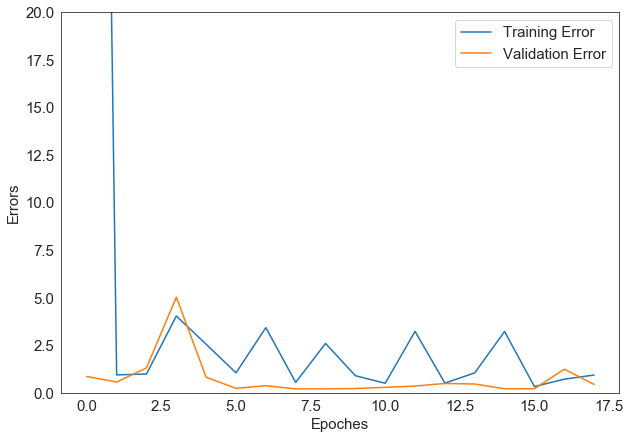

In [21]:
fig1=plt.subplot(1,1,1)
fig1.plot(train_errors_init,label='Training Error')
fig1.plot(valid_errors_init,label='Validation Error')
fig1.set_ylim((0,20))
fig1.legend()
fig1.set_xlabel('Epoches',fontsize=20)
fig1.set_ylabel('Errors',fontsize=20)

Text(0, 0.5, 'Errors')

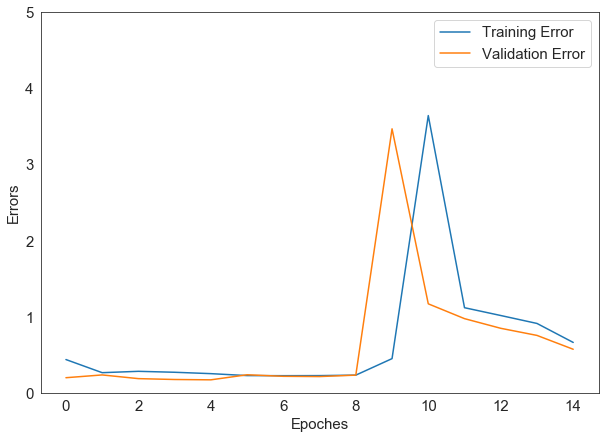

In [22]:
fig2=plt.subplot(1,1,1)
fig2.plot(train_errors_finetune,label='Training Error')
fig2.plot(valid_errors_finetune,label='Validation Error')
fig2.set_ylim((0,5))
fig2.legend()
fig2.set_xlabel('Epoches',fontsize=20)
fig2.set_ylabel('Errors',fontsize=20)

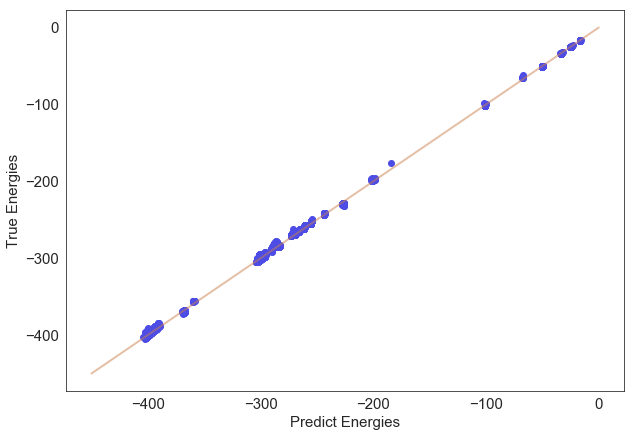

In [23]:
fig2=plt.subplot(1,1,1)
fig2.plot(np.linspace(-450,0),np.linspace(-450,0),linewidth=2,color=[0,0,0,1],zorder=0)
fig2.scatter(pred_energies.flat,true_energies.flat,color='#FF7C006F',zorder=1)
fig2.set_xlabel('Predict Energies/eV',fontsize=20)
fig2.set_ylabel('True Energies/eV',fontsize=20)
fig2.set_xlim([-450,0])
fig2.set_ylim([-450,0])

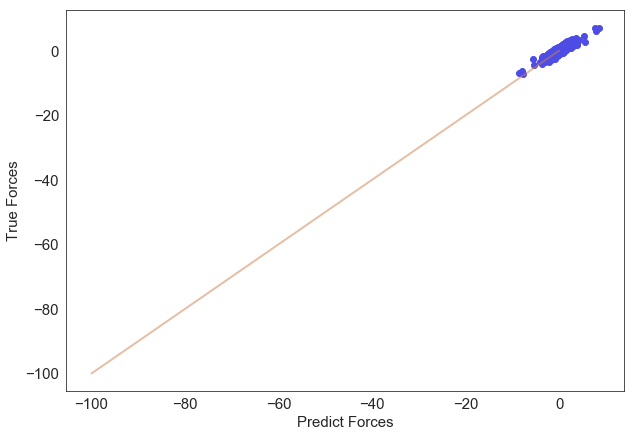

In [24]:
fig3=plt.subplot(1,1,1)
fig3.plot(np.linspace(-80,80),np.linspace(-80,80),linewidth=2,color=[0,0,0,1],zorder=0)
fig3.scatter(pred_forces.flat,true_forces.flat,color='#0190AB6F',zorder=1)
fig3.set_xlabel(r'Predict Forces/eV·Angstrom$^{-1}$',fontsize=20)
fig3.set_ylabel(r'True Forces/eV·Angstrom$^{-1}$',fontsize=20)
fig3.set_xlim([-80,80])
fig3.set_ylim([-80,80])

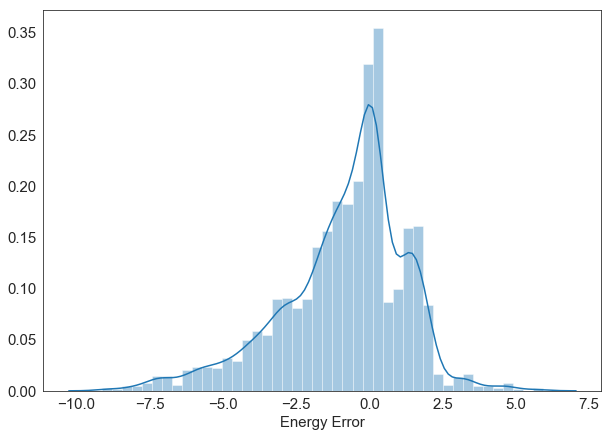

In [26]:
fig4=plt.subplot(1,1,1)
fig4.hist((pred_energies-true_energies)/true_energies,bins=100,edgecolor='white',color='#FF7C005F',linewidth=1,log=True)
fig4.set_xlabel('Energy Error/eV',fontsize=20)
fig4.set_ylabel('Count',fontsize=20)
fig4.set_ylim(0,10000)
#sns.distplot(pred_energies-true_energies,axlabel='Energy Error/eV',bins=60,norm_hist=False,
#            hist_kws={'edgecolor':'white','linewidth':1})

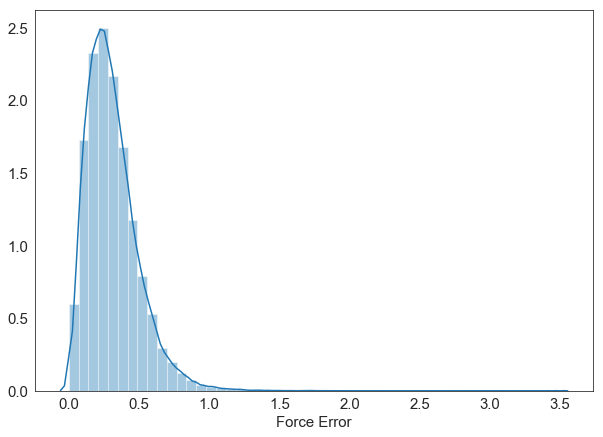

In [27]:
fig5=plt.subplot(1,1,1)
fig5.hist(np.linalg.norm(pred_forces-true_forces,ord=2,axis=1),bins=100,edgecolor='white',color='#0190AB5F',linewidth=1,log=True)
fig5.set_xlabel(r'Force Error/eV·Angstrom$^{-1}$',fontsize=20)
fig5.set_ylabel('Count',fontsize=20)
fig5.set_ylim(0,100000)
#sns.distplot(np.linalg.norm(pred_forces-true_forces,ord=2,axis=1),axlabel='Force Error/(eV/Angstrom)',bins=60)

To view the calculation graph, uncomment the following code.

In [28]:
# def make_dot(var, params=None):
#     """ Produces Graphviz representation of PyTorch autograd graph
#     Blue nodes are the Variables that require grad, orange are Tensors
#     saved for backward in torch.autograd.Function
#     Args:
#         var: output Variable
#         params: dict of (name, Variable) to add names to node that
#             require grad (TODO: make optional)
#     """
#     if params is not None:
#         assert isinstance(params.values()[0], Variable)
#         param_map = {id(v): k for k, v in params.items()}
 
#     node_attr = dict(style='filled',
#                      shape='box',
#                      align='left',
#                      fontsize='12',
#                      ranksep='0.1',
#                      height='0.2')
#     dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
#     seen = set()
 
#     def size_to_str(size):
#         return '('+(', ').join(['%d' % v for v in size])+')'
 
#     def add_nodes(var):
#         if var not in seen:
#             if torch.is_tensor(var):
#                 dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
#             elif hasattr(var, 'variable'):
#                 u = var.variable
#                 name = param_map[id(u)] if params is not None else ''
#                 node_name = '%s\n %s' % (name, size_to_str(u.size()))
#                 dot.node(str(id(var)), node_name, fillcolor='lightblue')
#             else:
#                 dot.node(str(id(var)), str(type(var).__name__))
#             seen.add(var)
#             if hasattr(var, 'next_functions'):
#                 for u in var.next_functions:
#                     if u[0] is not None:
#                         dot.edge(str(id(u[0])), str(id(var)))
#                         add_nodes(u[0])
#             if hasattr(var, 'saved_tensors'):
#                 for t in var.saved_tensors:
#                     dot.edge(str(id(t)), str(id(var)))
#                     add_nodes(t)
#     add_nodes(var.grad_fn)
#     return dot

# temp_for_graph,energy_temp=graph_data[0]
# temp_res=model(temp_for_graph)
# g=make_dot(temp_res)
# g.view()